In [15]:
# Function for importing and parsing Quantius results
from QuantiusResult import importAnnotations

import pandas as pd

# Modules for plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Modules for clustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

%matplotlib inline

# Objective
This notebook explores the analysis of crowd-sourced annotation of RNA FISH data.

# Data set
The annotated images are crops of an image of fluorescence image of 100 nm fluorescent beads embedded in mouse lung tissue. The images were acquired on a widefield epifluorescence microscope with a 40x 1.10 NA water immersion objective (pixels are 162.5 x 162. nm^2 in the sample plane). The image was annotated by 20 people on Mechanical Turk via Quantius. The data are imported via the function importAnnotations() into a Pandas DataFrame with the following columns:

annotation DataFrame columns (each row is an annotation):
* timestamp - this is a timestamp for the annotation, but I am unsure of the units - need to discuss with Quantius
* x - the x-coordinate of the annotation
* y - the y-coordinate of the annotation
* annotation_type - the type of annotation that was requested. "crosshair" is used for point selection.
* height - height of the image in pixels
* width - width of the image in pixels
* image_filename - filename of the image that was annotated
    * There were 5 images annoated. They are all crops (aligned in the upper left hand corner) of the same image to assess the effect of number of objects on Turker performance
    * The images are located in the "Crops" subdirectory and named "beads_(crop size)pxroi.png" 
* time_when_completed - time when the worker finished annotating the image
* worker_id - unique identifier for the worker that performed the annotation

Note that for the coordinates, the origin (0, 0) is in the upper left hand corner of the image with +x to the right and +y down.

# Reference annotation format
* Table schema (each table row is a spot): 
	* | row | col | c | A | row_fit | col_fit | sigma_x | sigma_y |
* coordinates (row, col) are the indices of the pixel from the upper left hand corner, indexed from 1.
* c, A, row_fit, col_fit, sigma_x, and sigma_y are the parameters to a 2D fit for each manually-identified spot where
     f = c + A*exp( -((x-row_fit)^2) / (2*sigma_x^2)) - ((y-col_fit)^2) / (2*sigma_y^2)) )


# Load the data

In [2]:
anno_all = importAnnotations('BeadAnnotation_20180413.json')

anno = anno_all[anno_all.image_filename == 'beads_300pxroi.png']

In [7]:
# Import the reference annotations
ref_anno = pd.read_csv('./Crops/bead_annotations_20180517.csv')

# Extract the coordintes of the reference annotation
# Subtract one because the ref coordinates are indexed from 1.
ref_coords = ref_anno.loc[:, ['col_fit', 'row_fit']].as_matrix() - 1

# Cluster the data
We use affinity propogation to cluster the annotations to generate a consensus.

In [8]:
coords = anno.loc[:, ['x', 'y']].as_matrix()

af = AffinityPropagation(preference=-100).fit(coords)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

# Visualize the image
Here we overlay the cluster centroids (colored empty circles) and the reference points (transluscent magenta circles) on the original image.

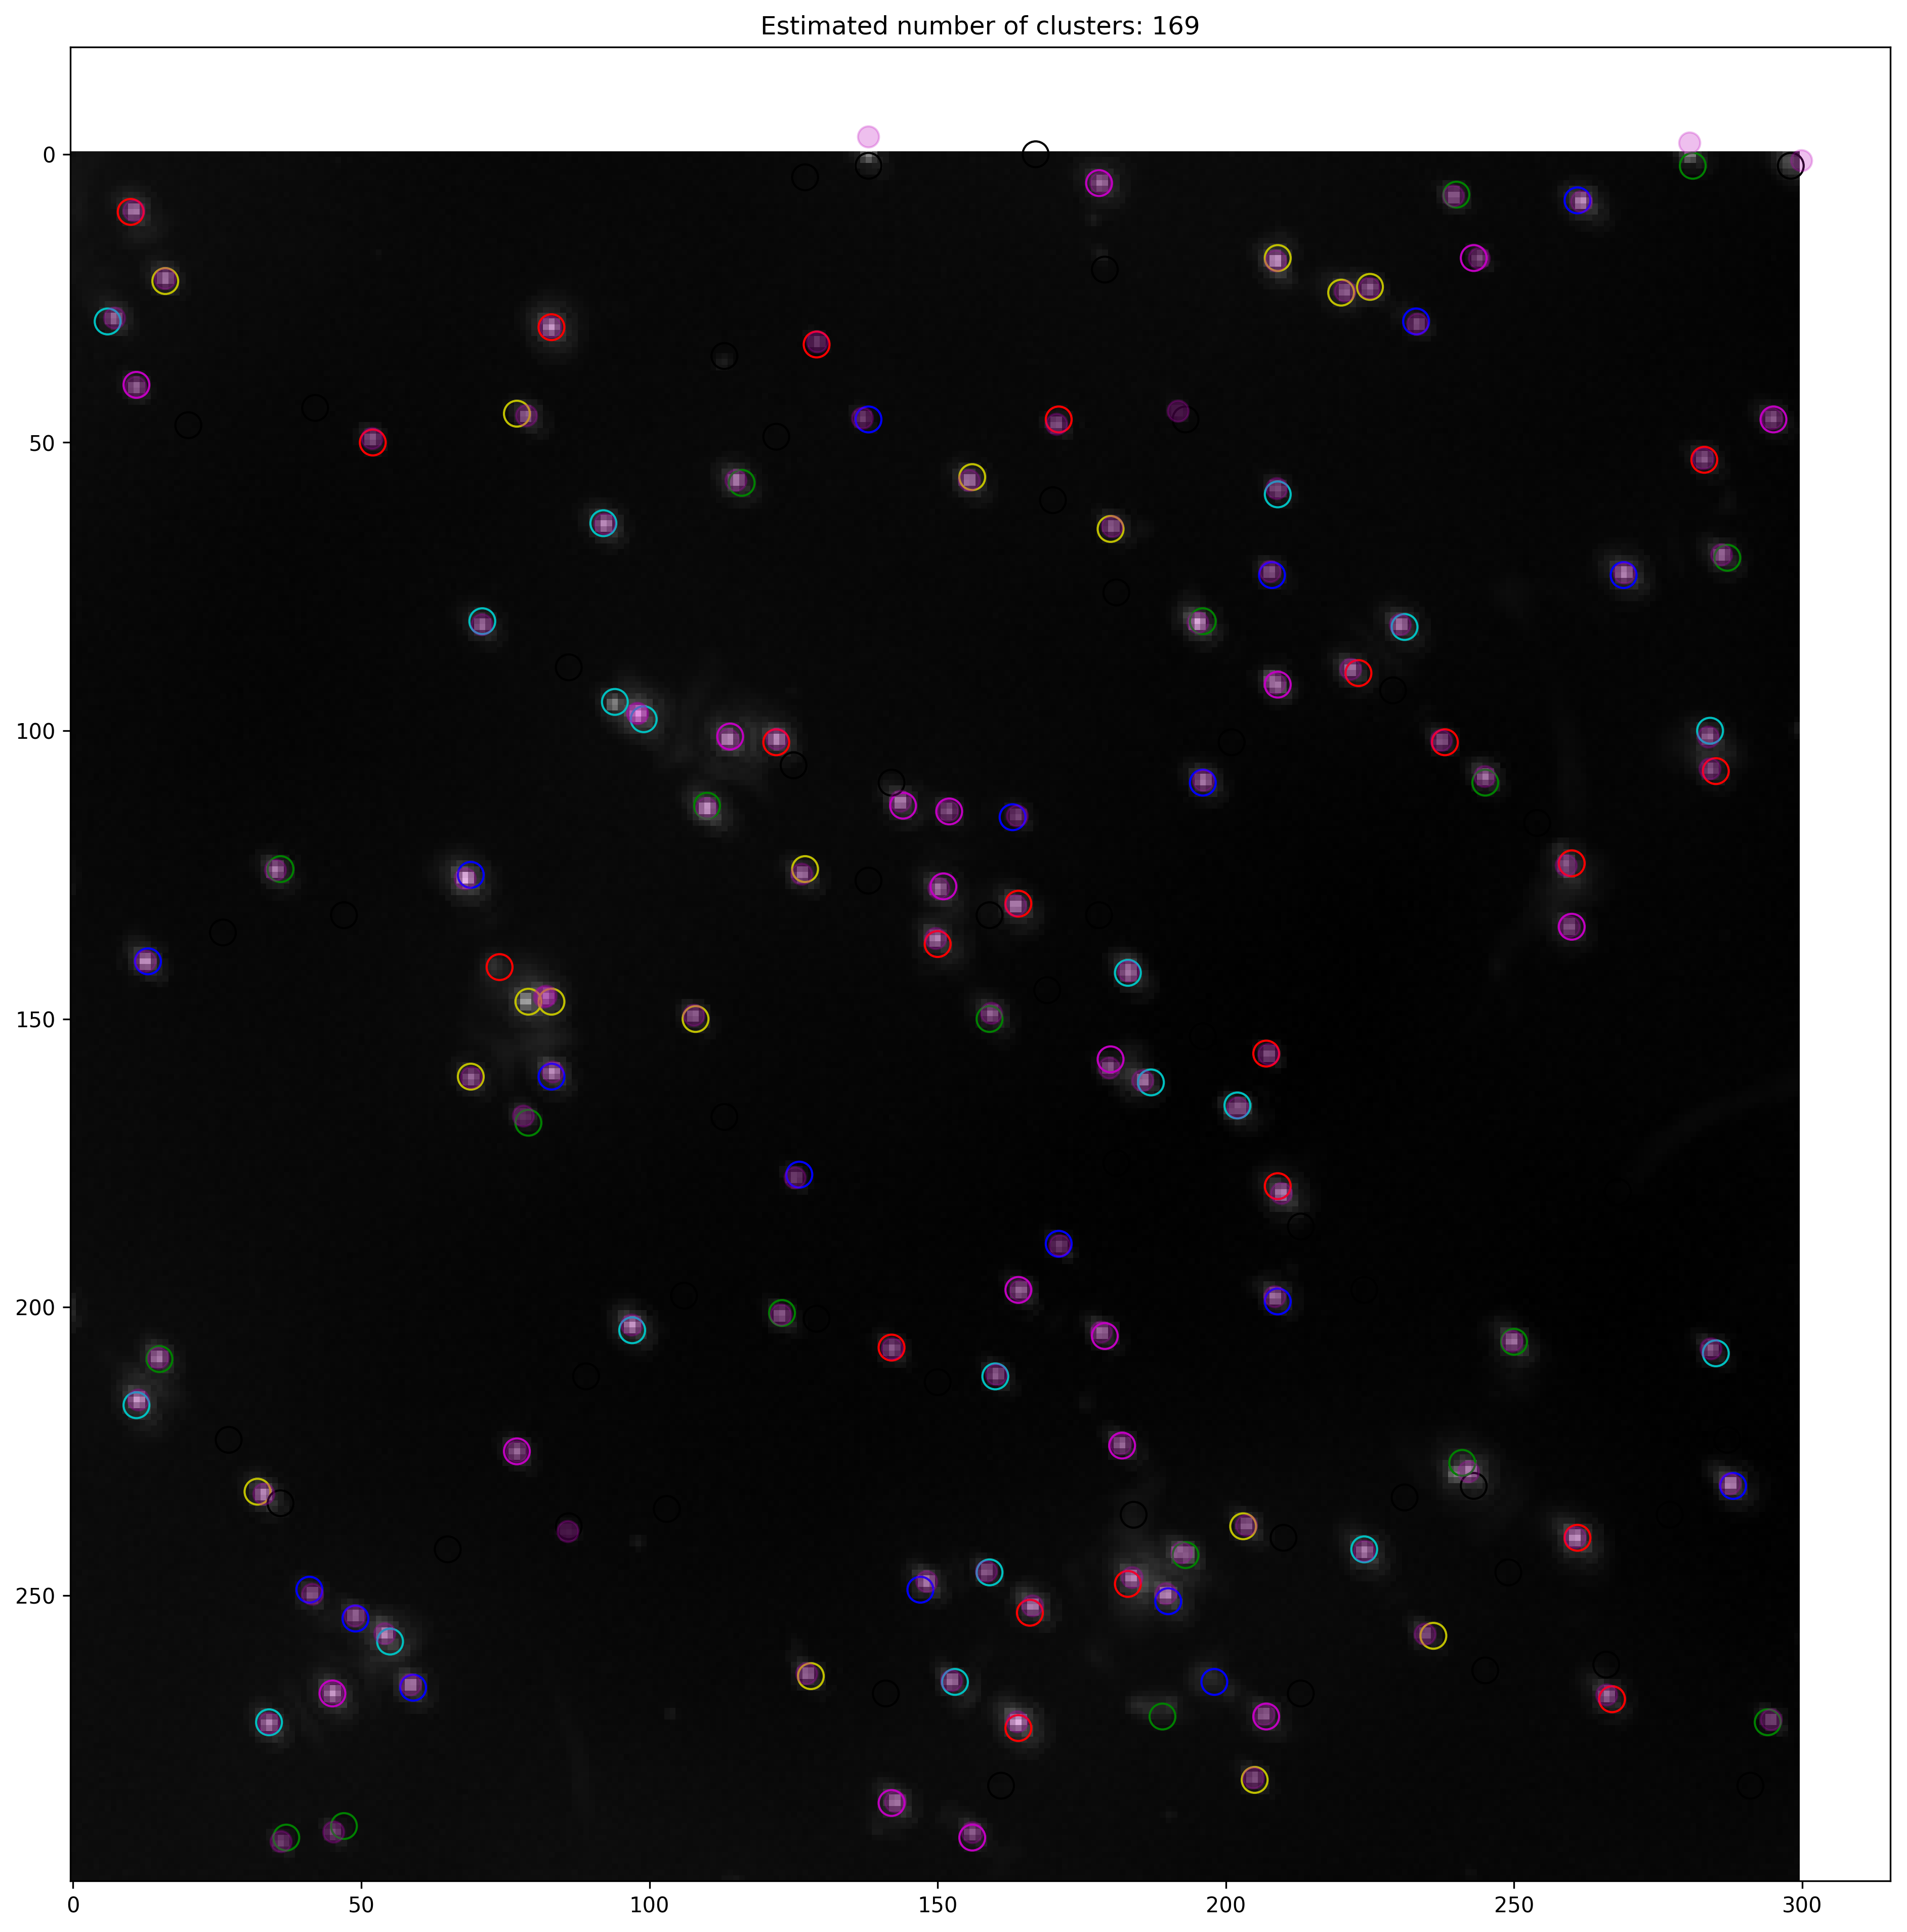

In [13]:
# Plot result
from itertools import cycle

# Set the size of the image (for transforming the axes)
# This can also be extracted from the "height" field of the annotation dataframe
crop_size = 300

fig=plt.figure(figsize=(18, 16), dpi= 300)

# Load the image
img = mpimg.imread('./Crops/beads_300pxroi.png')
imgplot = plt.imshow(img, cmap='gray')

colors = cycle('bgrcmybgrcmybgrcmybgrcmy')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    
    # Color all points/entroids with fewer than 50% of the turkers represented black
    if sum(class_members) < 10:
        col = 'k'
    
    cluster_center = coords[cluster_centers_indices[k]]
    
    # Plot each individual annotation
    #plt.plot(coords[class_members, 0], crop_size - coords[class_members, 1], col + '.')
    
    # Plot the cluster centers
    plt.scatter(cluster_center[0], crop_size - cluster_center[1], facecolors='none', edgecolor = col, s = 150)
    
    
# Plot the reference points as translucent magenta circles
plt.scatter(ref_coords[:, 0], ref_coords[:, 1], s = 100, facecolors = 'm', alpha = 0.25)
    
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Worker representation in each cluster
Given our observation above that some clusters contain annotations from a small fraction of the workers, we created the histogram of number of workers represented in each cluster. There were 20 total workers. We see two rough groupings of results, divided at 10 (50%) workers. Further replicates are required to understand this behavior, but fraction of workers represented in a cluster may be a useful metric for quality control (i.e., determining if a cluster is "real").

(0, 20)

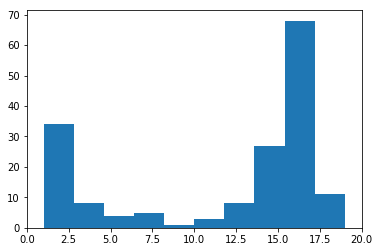

In [34]:
n_class_members = []

for i in range(n_clusters_):
    class_members = labels == i
    n_class_members.append(sum(class_members))
    
plt.hist(n_class_members, 10)
plt.xlim((0, 20))

# Sensitivity of the clustering to the preference parameter
Next, to understand the sensitivity of the clusters to the choice in the preference parameter, we swept the parameter from -200 to 0. We observed high stability for preference < -50, with a rapid fragmentation of clusters as preference approaches 0. Further experimentation is warranted, but the stability is promising.

In [ ]:
import numpy as np

# Test the sensitivity of the "preference" parameter

n_clusters = []
prefs = []

for pref in np.arange(-200, 0):
    af = AffinityPropagation(preference=pref).fit(coords)
    cluster_centers_indices = af.cluster_centers_indices_
    
    n_clusters.append(len(cluster_centers_indices))
    prefs.append(pref)
    

In [ ]:
plt.plot(prefs, n_clusters)
plt.xlabel('Preference')
plt.ylabel('Number of clusters')

# Number of turkers required to reach a consensus
To understand the number of required workers to reach a consensus, we resampled the data with with varying numbers of workers (1-20 workers, 50 draws each). The number of clusters detected approaches the full workers value.


In [ ]:
# Resample
pref = -100

# Get the number of workers and worker IDs
worker_ids = anno.worker_id.unique()
total_turkers = len(worker_ids)

n_clusters = []
n_samples = []

for n_turkers in np.arange(1, 20):
        
    n_clust_subsample = []
    
    for i in range(50):
        # Get the subsampled data
        indices = np.random.choice(total_turkers, n_turkers, replace=False)
        
        worker_subsample= worker_ids[indices]
        
        coords = anno.loc[anno['worker_id'].isin(worker_subsample), ['x', 'y']]
        
        # Calculate the number of clusters
        af = AffinityPropagation(preference=pref).fit(coords)
        cluster_centers_indices = af.cluster_centers_indices_
    
        n_clust_subsample.append(len(cluster_centers_indices))

    
    # Save the data to the lists
    n_clusters.append(n_clust_subsample)
    n_samples.append(n_turkers)


In [ ]:
# Plot the subsampling results

means = np.mean(n_clusters, axis = 1)
stds = np.std(n_clusters, axis = 1)


plt.errorbar(n_samples, means, yerr = stds)
#plt.plot(n_samples, means, 'k-')
#plt.fill_between(n_samples, means-stds, means+stds, alpha=0.5, edgecolor=None)

plt.ylim((0, 40))
plt.xlabel('Number of workers')
plt.ylabel('Number of clusters')
    

In [ ]:
plt.plot(n_samples, stds / means * 100)
plt.xlabel('Number of workers')
plt.ylabel('Coefficient of variation [%]')